In [11]:
import torch 
torch.cuda.is_available()

True

In [12]:
torch.cuda.memory_allocated()

575063040

In [13]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [14]:
import torch
from torchvision import models

vgg= models.vgg19(pretrained=True)

In [15]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
vgg.to(device=device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
from PIL import Image
from torchvision import transforms as T

In [18]:
def preprocess(img_path,max_size=500):
  img=Image.open(img_path).convert('RGB')
  if max(img.size)>max_size:
    size=max_size
  else:
    size=max_size

  img_transform= T.Compose(
      [
       T.Resize(size),
       T.ToTensor(),
       T.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229,0.224,0.225])
      ]
  )
  img=img_transform(img)
  img=img.unsqueeze(0)

  return img

In [19]:
content_p=preprocess('Content3.jpg')
style_p=preprocess('style3.jpeg')

In [20]:
content_p=content_p.to(device)
style_p=style_p.to(device)

In [21]:
content_p.shape

torch.Size([1, 3, 666, 500])

In [22]:
def get_features(img,model,layers=None):
 
  layers= {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
  }

  x=img

  Features={}
  for name,layer in enumerate(model.features):
    x=layer(x)
    if str(name) in layers:
      
      Features[layers[str(name)]]=x

  return Features


In [23]:
content_f=get_features(content_p,vgg)

In [24]:
content_f

{'conv1_1': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0591, 0.0987, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[1.4307, 0.0000, 0.0000,  ..., 1.2331, 1.2639, 2.7743],
           [3.4114, 0.1662, 0.0000,  ..., 0.2273, 0.1803, 2.6520],
           [3.5042, 0.2044, 0.0644,  ..., 0.2370, 0.1655, 2.6684],
           ...,
           [3.2070, 0.0000, 0.0000,  ..., 0.1954, 0.3129, 0.0000],
           [3.2323, 0.0000, 0.0000,  ..., 0.3760, 0.4680, 0.0000],
           [4.3743, 2.1242, 2.1146,  ..., 1.5533, 1.5906, 0.1817]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0648, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.1035, 0.2182, 0.0000],
           [0

In [25]:
style_f=get_features(style_p,vgg)

In [26]:
def gram_matrix(tensor):
    b,c,h,w=tensor.size()
    tensor=tensor.view(c,h*w)
    gram=torch.mm(tensor,tensor.t())
    return gram


In [27]:
style_grams= { layer: gram_matrix(style_f[layer]) for layer in style_f}

In [28]:
style_grams

{'conv1_1': tensor([[467760.5938, 101111.8828, 310355.5938,  ..., 117111.9297,
           56867.2227, 136831.5000],
         [101111.8828, 271029.5625,  58105.3398,  ...,  85654.5703,
           34677.2070, 140864.4062],
         [310355.5938,  58105.3398, 227369.2812,  ...,  49925.4492,
           37872.6289,  92095.0312],
         ...,
         [117111.9297,  85654.5703,  49925.4492,  ..., 366447.0625,
           67014.5859, 113707.2969],
         [ 56867.2227,  34677.2070,  37872.6289,  ...,  67014.5859,
           63736.2305,  48693.5234],
         [136831.5000, 140864.4062,  92095.0312,  ..., 113707.2969,
           48693.5234, 300272.7812]], device='cuda:0', grad_fn=<MmBackward0>),
 'conv2_1': tensor([[198085.3125,  15770.4932,  82192.3359,  ...,  93045.8828,
           45975.1836,  69553.3516],
         [ 15770.4932,  93618.5234,  24504.4180,  ..., 159913.7031,
           40903.9922,  19758.7422],
         [ 82192.3359,  24504.4180, 167857.6406,  ..., 100020.6875,
           248

In [29]:
def content_loss(target_conv4_2,content_conv4_2):
    loss= torch.mean((target_conv4_2-content_conv4_2)**2)
    return loss

In [30]:
style_weights={
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

In [31]:
def style_loss(style_weights,target_features,style_grams):

    loss=0

    for layer in style_weights:
        target_f=target_features[layer]
        target_gram= gram_matrix(target_f)
        style_gram=style_grams[layer]
        b,c,h,w= target_f.shape
        layer_loss= style_weights[layer]*torch.mean((target_gram-style_gram)**2)
        loss+=layer_loss/(c*h*w)

    return loss


In [32]:
target=content_p.clone().requires_grad_(True).to(device)
target_f=get_features(target,vgg)

In [33]:
content_loss(target_f['conv4_2'],content_f['conv4_2'])

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
print(style_loss(style_weights=style_weights,target_features=target_f,style_grams=style_grams))

tensor(297.6827, device='cuda:0', grad_fn=<AddBackward0>)


In [35]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):

  img= tensor.to("cpu").clone()
  img= img.numpy()
  img= img.squeeze(0)
  img= img.transpose(1,2,0)
  img=img*np.array([0.485, 0.456, 0.406])+np.array([0.229,0.224,0.225])
  img=img.clip(0,1)

  return img

In [36]:
content_d=deprocess(content_p)
style_d=deprocess(style_p)

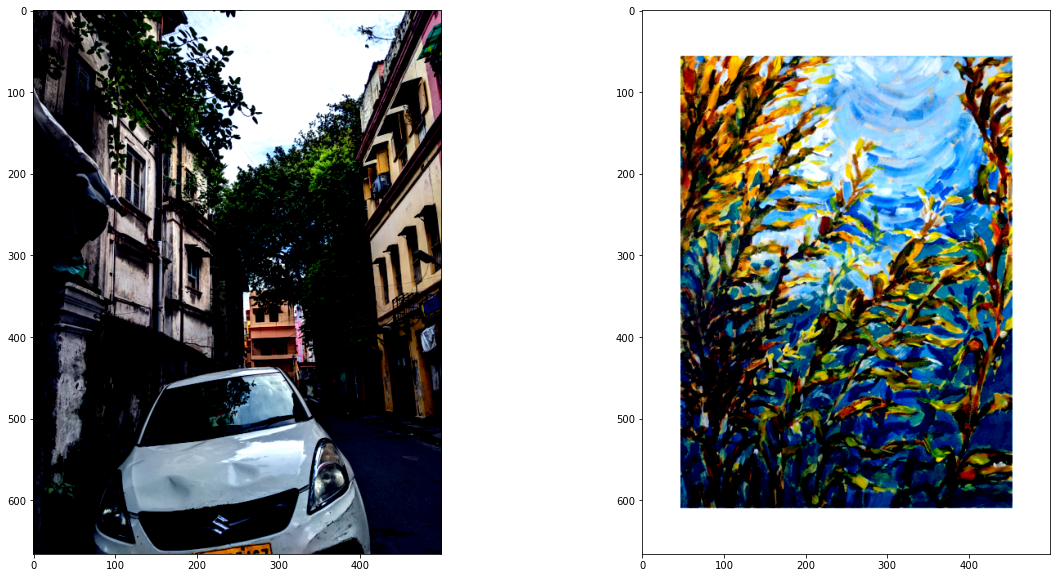

In [37]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

In [38]:
from torch import optim

optimizer=optim.Adam([target],lr=0.003)

alpha=1
beta=1e5
epochs=4500
show_every=500

In [39]:
def total_loss(c_loss,s_loss,alpha,beta):
    t_loss= c_loss*alpha + s_loss*beta
    return t_loss

In [40]:
results=[]

for each_epoch in range(epochs):
    target_f=get_features(target,vgg)
    
    c_loss=content_loss(target_f['conv4_2'],content_f['conv4_2'])
    s_loss=style_loss(style_weights,target_f,style_grams)
    t_loss=total_loss(c_loss,s_loss,alpha,beta)

    optimizer.zero_grad()
    t_loss.backward(retain_graph=True)
    optimizer.step()

    if each_epoch%show_every==0:
        print(f"Total Loss at Epoch {each_epoch} : {t_loss}")
        results.append(deprocess(target.detach()))

Total Loss at Epoch 0 : 29768274.0
Total Loss at Epoch 500 : 2359865.5
Total Loss at Epoch 1000 : 1331096.75
Total Loss at Epoch 1500 : 806531.0
Total Loss at Epoch 2000 : 539187.5
Total Loss at Epoch 2500 : 403838.4375
Total Loss at Epoch 3000 : 325586.09375
Total Loss at Epoch 3500 : 268770.78125
Total Loss at Epoch 4000 : 222829.328125


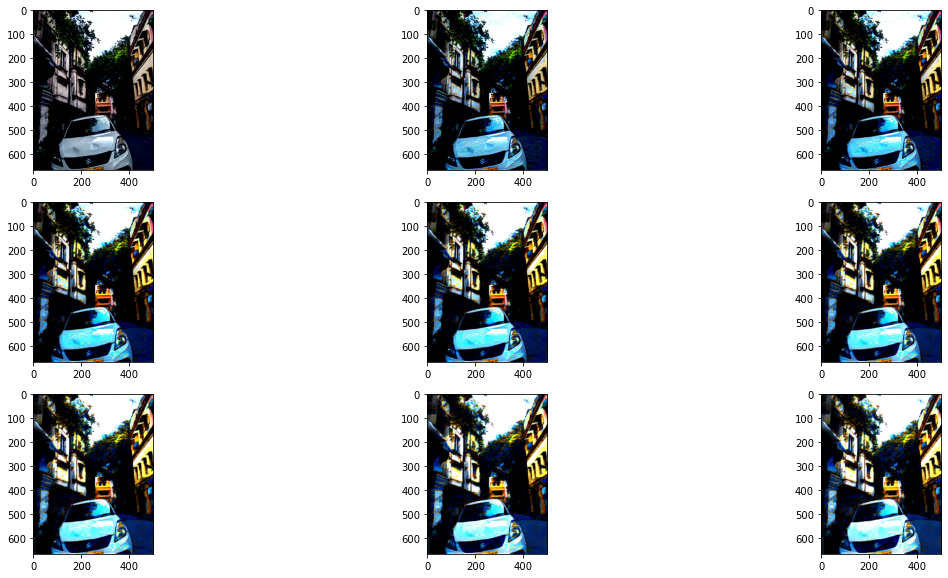

In [41]:
plt.figure(figsize=(20,10))

for i in range(len(results)):
    plt.subplot(3,3,i+1)
    plt.imshow(results[i])

plt.show()

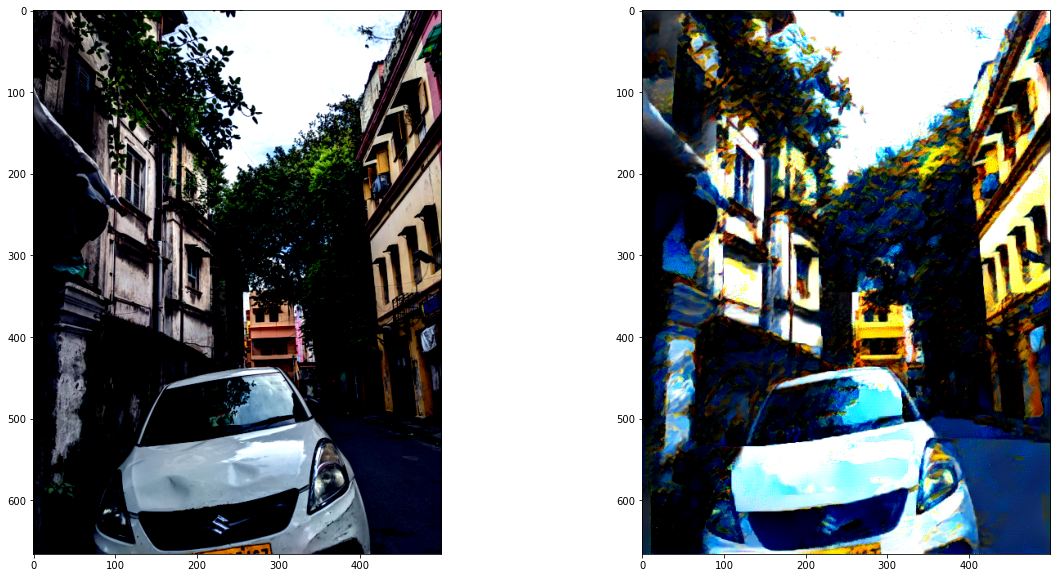

In [42]:
target_copy=deprocess(target.detach())
content_copy=deprocess(content_p)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_copy)
ax2.imshow(target_copy)